In [194]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns


reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [200]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/"
imaging_scheme = "TL/470/410/470/410"

reload(experiment);
ex = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme
)

04:28:17 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/
04:28:17 INFO:Loading Images
04:28:17 INFO:Segmenting pharynxes
04:28:19 INFO:Centering and rotating pharynxes
04:28:27 INFO:Calculating midlines
04:28:29 INFO:Measuring under midlines
04:28:33 INFO:Trimming intensity data
04:28:34 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
04:28:34 INFO:Finished full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation


In [201]:
ex.trimmed_intensity_data

<xarray.DataArray (strain: 123, wavelength: 5, pair: 2, position: 100)>
array([[[[2101.800852, ..., 2873.64167 ],
         [2904.267358, ..., 2105.933287]],

        ...,

        [[-291.854437, ..., -277.0511  ],
         [        nan, ..., -268.616449]]],


       ...,


       [[[2027.933501, ..., 2810.700072],
         [2183.384433, ..., 2723.193147]],

        ...,

        [[-273.992321, ..., -283.42023 ],
         [-277.436376, ..., -284.324416]]]])
Coordinates:
  * wavelength  (wavelength) object '470' '410' 'r' 'oxd' 'e'
  * strain      (strain) object 'HD233' 'HD233' 'HD233' ... 'SAY195' 'SAY195'
  * pair        (pair) int64 0 1
Dimensions without coordinates: position
Attributes:
    r_min:               0.852
    r_max:               6.65
    instrument_factor:   0.171
    midpoint_potential:  -265.0
    z:                   2
    temperature:         22.0

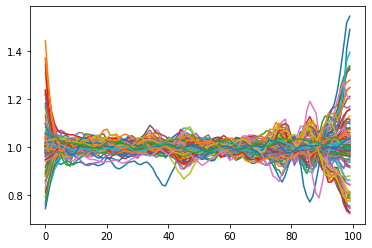

In [191]:
r_r = ex.trimmed_intensity_data.sel(wavelength='r', pair=0) / ex.trimmed_intensity_data.sel(wavelength='r', pair=1)
plt.plot(r_r.T);

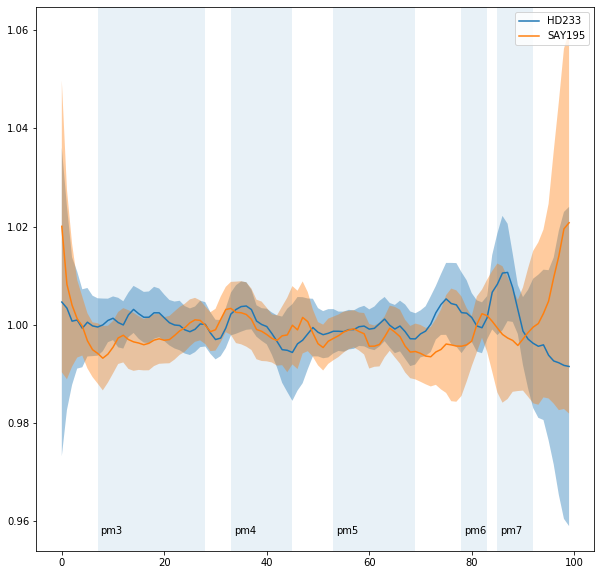

In [193]:
ax = plots.plot_average_by_strain_and_pair(r_r)

In [8]:
from skfda import FDataGrid
import skfda

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x113a33cc0>])

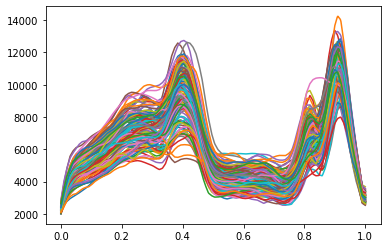

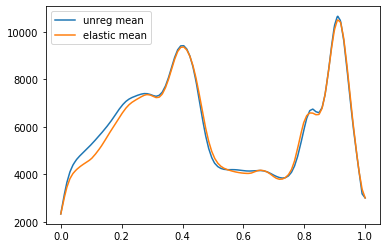

<Figure size 432x288 with 0 Axes>

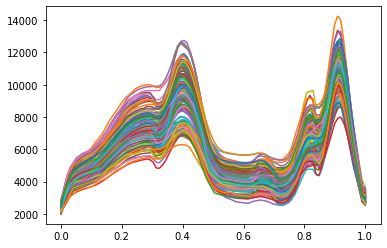

In [11]:
fd = FDataGrid(ex.trimmed_intensity_data.sel(pair=0, wavelength='410'))

plt.figure()
fd.plot()

plt.figure()
fd.mean().plot(label='unreg mean')
skfda.preprocessing.registration.elastic_mean(fd).plot(label='elastic mean')
plt.legend()

plt.figure()
fd_align = skfda.preprocessing.registration.elastic_registration(fd)
plt.figure()
fd_align.plot()

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1362ddf98>])

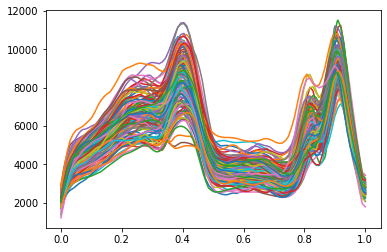

<Figure size 432x288 with 0 Axes>

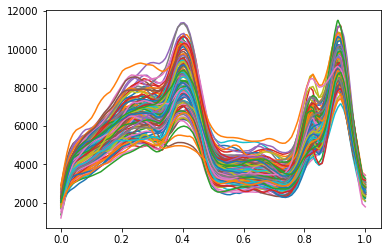

In [159]:
fd = FDataGrid(ex.trimmed_intensity_data.sel(pair=0, wavelength='470'))

plt.figure()
fd.plot()

plt.figure()
fd_align = skfda.preprocessing.registration.elastic_registration(fd, lam=.1)
plt.figure()
fd_align.plot()

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x136a702e8>])

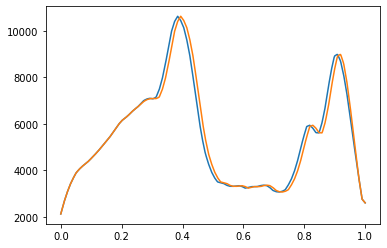

In [165]:
i=5
fd[i].plot()
fd_align[i].plot()

In [176]:
fd410_0 = FDataGrid(ex.trimmed_intensity_data.sel(pair=0, wavelength='410'))
fd470_0 = FDataGrid(ex.trimmed_intensity_data.sel(pair=0, wavelength='470'))
fd410_1 = FDataGrid(ex.trimmed_intensity_data.sel(pair=1, wavelength='410'))
fd470_1 = FDataGrid(ex.trimmed_intensity_data.sel(pair=1, wavelength='470'))

fd_reg_410_0 = skfda.preprocessing.registration.elastic_registration(fd410_0, fd470_0, lam=2)
fd_reg_410_1 = skfda.preprocessing.registration.elastic_registration(fd410_1, fd470_0, lam=2)
fd_reg_470_1 = skfda.preprocessing.registration.elastic_registration(fd470_1, fd470_0, lam=2)

In [177]:
r_0 = fd_reg_410_0 / fd470_0
r_1 = fd_reg_410_1 / fd_reg_470_1

r_r = r_0 / r_1

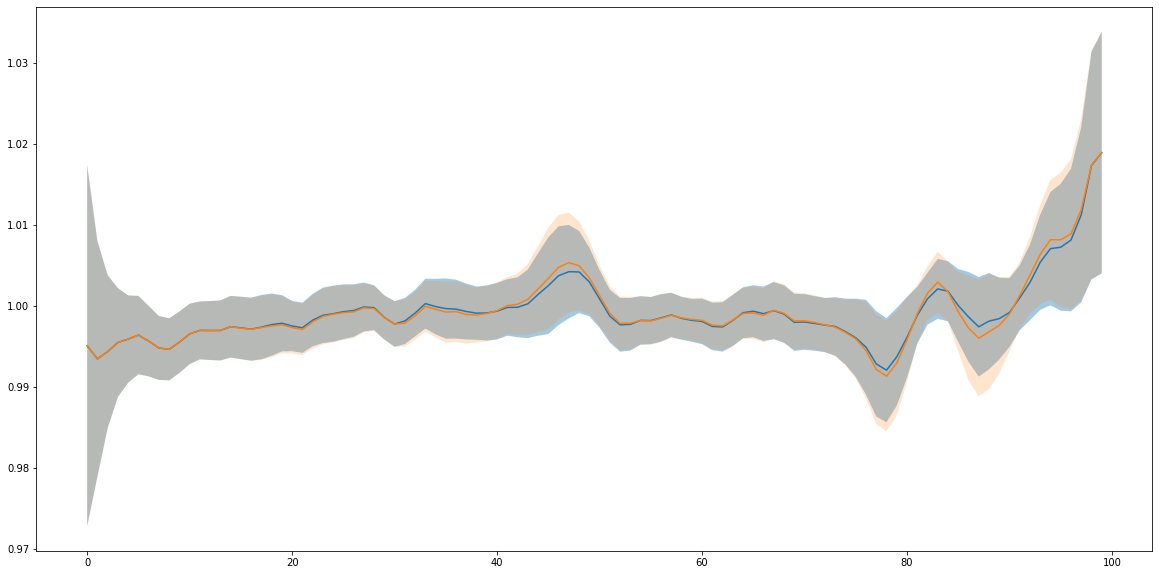

In [193]:
from statsmodels.stats.weightstats import DescrStatsW

plt.figure(figsize=(20,10))
lower, upper = DescrStatsW(r_r.data_matrix[:,:,0]).tconfint_mean()
xs = np.arange(len(lower))
plt.plot(np.mean(r_r.data_matrix[:,:,0], axis=0))
plt.fill_between(xs, lower, upper, alpha=.4)

lower, upper = DescrStatsW(rr).tconfint_mean()
xs = np.arange(len(lower))
plt.plot(np.mean(rr, axis=0))
plt.fill_between(xs, lower, upper, alpha=.2)


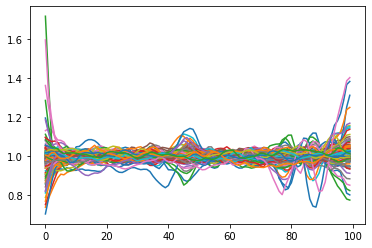

In [107]:
r0 = ex.trimmed_intensity_data.sel(pair=0, wavelength='410') / ex.trimmed_intensity_data.sel(pair=0, wavelength='470')
r1 = ex.trimmed_intensity_data.sel(pair=1, wavelength='410') / ex.trimmed_intensity_data.sel(pair=1, wavelength='470')
rr = r0/r1

plt.plot(rr.T);

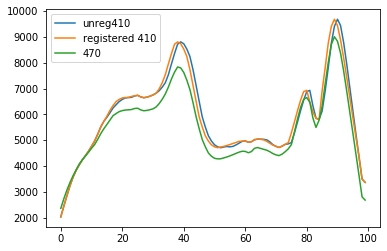

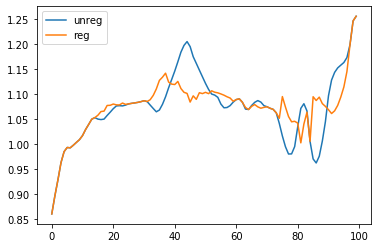

In [94]:
# i = 20
i = 41

unreg_410 = ex.trimmed_intensity_data.sel(pair=0, wavelength='410').isel(strain=i)
reg_410 = fd_registered[i].data_matrix[0,:,0]
reg_470 = fd470[i].data_matrix[0,:,0]

plt.plot(np.arange(100), unreg_410, label='unreg410')
plt.plot(reg_410, label='registered 410')
plt.plot(reg_470, label='470')
plt.legend()

plt.figure()
plt.plot(unreg_410 / reg_470, label='unreg')
plt.plot(reg_410 / reg_470, label='reg')
plt.legend()